In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn
from sklearn import linear_model
import numpy as np
import pickle
import xgboost as xgb
import time

In [2]:
# pull data from Mongodb server and return Numpy arrays
def gather_mongo_data():
    client = MongoClient('127.0.0.1', 3001)
    db = client.meteor
    images = list(db.facebook.find({}))

    df = pd.DataFrame(images)
    df = df.dropna(subset = ['normalized_log_likes'])
    # drop data with missing username
    df = df[df['user'] != 'profile.php']

    # build numpy array from DataFrame
    # there has to be a better way to do this -- I haven't investigated it yet
    likes = np.zeros((len(df), 1))
    pool = np.zeros((len(df), 2048))
    categories = np.zeros((len(df), 1008))
    facedata = np.zeros((len(df), 3))

    j = 0
    for i in df.index:
        likes[j, :] = df['normalized_log_likes'][i]
        pool[j, :] = df['inception_pool'][i]
        categories[j, :] = df['inception_classification'][i]
        facedata[j, :] = [df['faces'][i]['num'], df['faces'][i]['total'], df['faces'][i]['largest']]
        j += 1

    users = set(df['user'])
    users = list(users)
    user_hot = np.zeros((len(df), len(users)))
    user_num = np.zeros(len(df))

    j = 0
    for i in df.index:
        user_index = users.index(df['user'][i])
        user_num[j] = user_index
        user_hot[j, user_index] = 1
        j += 1

    predictors = np.hstack((pool, facedata))
    
    return (predictors, pool, likes, users, user_hot, user_num)

In [3]:
# calculate the n*(n-1)/2 comparisons of elements and measure how many of them are made correctly
def correct_comparisons(y, pred_y):
    comparison_true = (y.reshape(1,-1) - y.reshape(-1, 1)) > 0
    comparison_est = (pred_y.reshape(1,-1) - pred_y.reshape(-1,1)) > 0
        
    return ((np.sum(comparison_true == comparison_est) - len(y))/2, (len(y)**2 - len(y))/2)

In [4]:
# calculate all correct comparisons across test user set
def calculate_correct_comparisons(test_observations, test_users, user_hot, predicted_likes, likes):
    total_correct = 0
    total_comparisons = 0

    test_user_hot = user_hot[test_observations, :]
    
    for i in range(len(test_users)):
        user_test_set = np.any(test_user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
        
        ypred = np.ravel(predicted_likes[user_test_set])
        y = np.ravel(likes[user_test_set])

        (correct, total) = correct_comparisons(y, ypred)
        total_correct += correct
        total_comparisons += total

    return float(total_correct)/total_comparisons

In [5]:
# split the facebook dataset into training, validation, and test components

def split_datasets(users, user_hot, predictors, likes, seed=0):
    print('Seed value is: ' + str(seed))
    np.random.seed(seed)

    # choose 100 random users to be the test set
    test_users = np.random.choice(len(users), 200)
    test_set = np.any(user_hot[:, test_users], axis = 1).nonzero()[0]
    # choose ~100 random users to be the validation set
    validation_users = [v for v in np.random.choice(len(users), 206) if v not in test_users]
    validation_set = np.any(user_hot[:, validation_users], axis = 1).nonzero()[0]
    
    # training set is everything left
    training_users = [v for v in range(len(users)) if v not in test_users and v not in validation_users]
    training_set = [v for v in range(len(predictors)) if v not in test_set and v not in validation_set]

    print("Training set length: " + str(len(training_set)))
    print("Test set length: " + str(len(test_set)))
    print("Validation set length: " + str(len(validation_set)))
    
    return {"training": {"observations": training_set, "users": training_users, "X": predictors[training_set, :], "y": likes[training_set]}, 
            "validation": {"observations": validation_set, "users": validation_users, "X": predictors[validation_set, :], "y": likes[validation_set]}, 
            "test": {"observations": test_set, "users": test_users, "X": predictors[test_set, :], "y": likes[test_set]}}

In [7]:
(predictors, pool, likes, users, user_hot, user_num) = gather_mongo_data()

In [12]:
from sklearn import svm
from sklearn import preprocessing

In [28]:
data = split_datasets(users, user_hot, predictors, likes)

# scaler = preprocessing.StandardScaler().fit(data["training"]["X"])
# data["training"]["X"] = scaler.transform(data["training"]["X"])
# data["validation"]["X"] = scaler.transform(data["validation"]["X"])

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450


In [30]:
# for C in [0.07, 0.1, 0.13]:
#     for epsilon in [0.4, 0.45, 0.5]:


for gamma in [0.0002, 1./2051]:
    svr_simple = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', gamma = gamma, cache_size=4000)
    svr_simple.fit(data["training"]["X"][:5000,:], np.ravel(data["training"]["y"][:5000,:]))
    print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr_simple.score(data["validation"]["X"], data["validation"]["y"])))

    pred_likes_simple = svr_simple.predict(data["validation"]["X"])
    true_score_simple = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes_simple, data["validation"]["y"])
    print("    real score: " + str(true_score_simple))

C: 0.09, epsilon: 0.45 score: 0.0130097199318
    real score: 0.56196125288
C: 0.09, epsilon: 0.45 score: 0.0155013002237
    real score: 0.564103439447


In [ ]:
C = 0.5
epsilon = 0.45
gamma = 1./2051
svr_nouser = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', gamma = gamma, cache_size=12000)
svr_nouser.fit(data["training"]["X"][:,:], np.ravel(data["training"]["y"][:,:]))

In [ ]:
pickle.dump(svr_nouser, open("svr_nouser2.p","w"))

In [33]:
pred_likes_nouser = svr_nouser.predict(data["validation"]["X"])
correct_nouser = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes_nouser, data["validation"]["y"])
print("    percent correct: " + str(correct_nouser))

    percent correct: 0.553699752496


In [56]:
data = split_datasets(users, user_hot, predictors, likes)

scaler = preprocessing.StandardScaler().fit(data["training"]["X"])
data["training"]["X"] = scaler.transform(data["training"]["X"])
data["validation"]["X"] = scaler.transform(data["validation"]["X"])

for C in [0.01, 0.1, 1]:
    for epsilon in [0.01, 0.1, 1]:
# C = 0.01
# epsilon = 0.2
        svr_simple = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr_simple.fit(data["training"]["X"][:5000,:], np.ravel(data["training"]["y"][:5000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr_simple.score(data["validation"]["X"], data["validation"]["y"])))

        pred_likes_simple = svr_simple.predict(data["validation"]["X"])
        true_score_simple = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes_simple, data["validation"]["y"])
        print("    score: " + str(svr_simple.score(data["validation"]["X"], data["validation"]["y"])))
        print("    real score: " + str(true_score_simple))

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450
C: 0.01, epsilon: 0.01 score: 0.00568968682128
    score: 0.00568968682128
    real score: 0.555927285141
C: 0.01, epsilon: 0.1 score: 0.00586957737924
    score: 0.00586957737924
    real score: 0.558291371511
C: 0.01, epsilon: 1 score: -0.00242482160939
    score: -0.00242482160939
    real score: 0.551583169753
C: 0.1, epsilon: 0.01 score: -0.00502789949055
    score: -0.00502789949055
    real score: 0.549219083383


KeyboardInterrupt: 

In [106]:
import random
calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, np.random.randn(len(pred_likes_simple)), data["validation"]["y"])

0.5109584364598446

In [55]:
# plt.scatter(data["validation"]["y"], pred_likes_simple)
svr_simple.score(data["training"]["X"][:5000,:], data["training"]["y"][:5000, :])

0.039507055211127518

In [34]:
data = split_datasets(users, user_hot, predictors, likes)

scaler = preprocessing.StandardScaler().fit(data["training"]["X"])
data["training"]["X"] = scaler.transform(data["training"]["X"])
data["validation"]["X"] = scaler.transform(data["validation"]["X"])

for C in [0.01, 0.1, 1]:
    for epsilon in [0.01, 0.1, 1]:
        svr = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr.fit(data["training"]["X"][:5000,:], np.ravel(data["training"]["y"][:5000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr.score(data["validation"]["X"], data["validation"]["y"])))
        
        pred_likes = svr.predict(data["validation"]["X"])
        true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
        print("    real score: " + str(true_score))

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450
C: 0.01, epsilon: 0.01 score: 0.00519256243457
    real score: 0.557540326022


KeyboardInterrupt: 

In [23]:
from sklearn import preprocessing

data = split_datasets(users, user_hot, np.hstack((predictors, user_hot)), likes)

# scaler = preprocessing.StandardScaler().fit(data["training"]["X"])
# data["training"]["X"] = scaler.transform(data["training"]["X"])
# data["validation"]["X"] = scaler.transform(data["validation"]["X"])
# data["validation"]["X"][:, 2051:] *= 0

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450


In [29]:
for C in [0.01, 0.1, 1]:
    for epsilon in [0.01, 0.1, 1]:
        svr = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr.fit(data["training"]["X"][:5000,:], np.ravel(data["training"]["y"][:5000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr.score(data["validation"]["X"], data["validation"]["y"])))
        
        pred_likes = svr.predict(data["validation"]["X"])
        true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
        print("    real score: " + str(true_score))

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450
C: 0.01, epsilon: 0.01 score: -0.00812206238551
    real score: 0.562567210037
C: 0.01, epsilon: 0.1 score: -0.00568986409616
    real score: 0.560006827686
C: 0.01, epsilon: 1 score: -0.00129197368884
    real score: 0.561440641803
C: 0.1, epsilon: 0.01 score: -0.0216780031569
    real score: 0.554066740633
C: 0.1, epsilon: 0.1 score: -0.0189323756251
    real score: 0.555526158573
C: 0.1, epsilon: 1 score: 0.00651721012412
    real score: 0.548766749168
C: 1, epsilon: 0.01 score: -0.0965883177747
    real score: 0.537594947512
C: 1, epsilon: 0.1 score: -0.0853646502684
    real score: 0.541298967312
C: 1, epsilon: 1 score: 0.00332005305835
    real score: 0.532858240164


In [32]:
for C in [0.001, 0.0001]:
    for epsilon in [0.01, 0.1, 1]:
        svr = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr.fit(data["training"]["X"][:5000,:], np.ravel(data["training"]["y"][:5000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr.score(data["validation"]["X"], data["validation"]["y"])))
        
        pred_likes = svr.predict(data["validation"]["X"])
        true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
        print("    real score: " + str(true_score))

C: 0.001, epsilon: 0.01 score: -0.000923820632597
    real score: 0.558095075531
C: 0.001, epsilon: 0.1 score: -0.00039579642731
    real score: 0.558718101903
C: 0.001, epsilon: 1 score: -0.0043518083233
    real score: 0.55072970897
C: 0.0001, epsilon: 0.01 score: -0.00249302795545
    real score: 0.557386703081
C: 0.0001, epsilon: 0.1 score: -0.00218985793134
    real score: 0.557967056414
C: 0.0001, epsilon: 1 score: -0.00469366830504
    real score: 0.550832124264


In [36]:
for C in [0.01]:
    for epsilon in [0.01, 0.1, 1]:
        t = time.time()
        svr = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr.fit(data["training"]["X"][:10000,:], np.ravel(data["training"]["y"][:10000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr.score(data["validation"]["X"], data["validation"]["y"])))
        print("time elapsed: " + str(time.time() - t))
        pred_likes = svr.predict(data["validation"]["X"])
        true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
        print("    real score: " + str(true_score))

C: 0.01, epsilon: 0.01 score: -0.00452431112474
time elapsed: 1220.42276597
    real score: 0.563685243663
C: 0.01, epsilon: 0.1 score: -0.00428093876819
time elapsed: 943.869235992
    real score: 0.563873005035
C: 0.01, epsilon: 1 score: -0.0013067120273
time elapsed: 31.1488521099
    real score: 0.552103780831


In [37]:
for C in [0.01]:
    for epsilon in [0.2, 0.3]:
        t = time.time()
        svr = svm.SVR(C = C, epsilon = epsilon, kernel = 'rbf', cache_size=4000)
        svr.fit(data["training"]["X"][:10000,:], np.ravel(data["training"]["y"][:10000,:]))
        print("C: " + str(C) + ", epsilon: " + str(epsilon) + " score: " + str(svr.score(data["validation"]["X"], data["validation"]["y"])))
        print("time elapsed: " + str(time.time() - t))
        pred_likes = svr.predict(data["validation"]["X"])
        true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
        print("    real score: " + str(true_score))

C: 0.01, epsilon: 0.2 score: -0.00199850135327
time elapsed: 699.244531155
    real score: 0.564350943074
C: 0.01, epsilon: 0.3 score: 0.00403571424925
time elapsed: 570.318196774
    real score: 0.563190236409


In [39]:
svr = svm.SVR(C = 0.01, epsilon = 0.2, kernel = 'rbf', cache_size=4000)
svr.fit(data["training"]["X"], np.ravel(data["training"]["y"]))

SVR(C=0.01, cache_size=4000, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
pickle.dump(svr, open("svr-c-0.01-e-0.2-rbf-full-user.p", "w"))

In [43]:
pred_likes = svr.predict(data["validation"]["X"])

In [44]:
true_score = calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])
print("    real score: " + str(true_score))

    real score: 0.565084919348


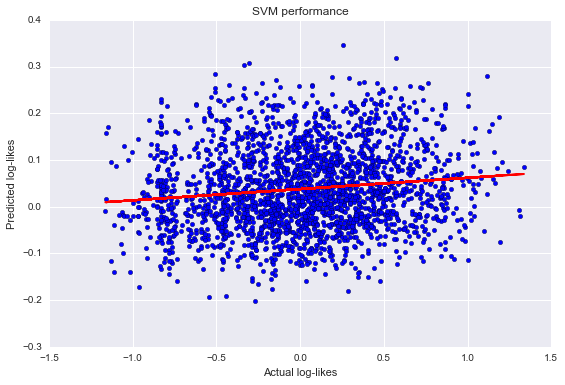

In [116]:
from sklearn import linear_model
lin = linear_model.LinearRegression().fit(data["validation"]["y"], pred_likes)
lin.score(data["validation"]["y"], pred_likes)

plt.scatter(data["validation"]["y"], pred_likes)
plt.plot(data["validation"]["y"], data["validation"]["y"]*lin.coef_ + lin.intercept_, color='red', linewidth=2)
plt.xlabel('Actual log-likes')
plt.ylabel('Predicted log-likes')
plt.title('SVM performance')
plt.tight_layout()
plt.savefig('svm_performance.png', dpi=300)

r^2: 0.00367067747592
r^2: 0.019081216317
r^2: 0.00030536770426
r^2: 0.0074603698317
r^2: 0.00579441290936
r^2: 0.0149338387055
r^2: 0.000961402129845
r^2: 0.0188966865237
r^2: 0.0310209877314
r^2: 0.00191860015488
r^2: 0.00822421123971
r^2: 0.05752657923
r^2: 2.51178208721e-06
r^2: 0.0101801710992
r^2: 0.0077673679081
r^2: 0.000554494366856
r^2: 0.0966358507694
r^2: 0.00619341117555
r^2: 0.0375100058466
r^2: 0.116233705999
r^2: 0.0686507539419
r^2: 0.00229196394644
r^2: 0.00349578875669
r^2: 0.0290438791498
r^2: 0.0135991319685
r^2: 0.286619211973
r^2: 0.000646028324743
r^2: 0.0024094145485
r^2: 0.0276317723828
r^2: 0.00836792060851
r^2: 0.0590542618137
r^2: 0.27806711286
r^2: 0.000231733609669
r^2: 6.36806983744e-05
r^2: 0.0474985480487


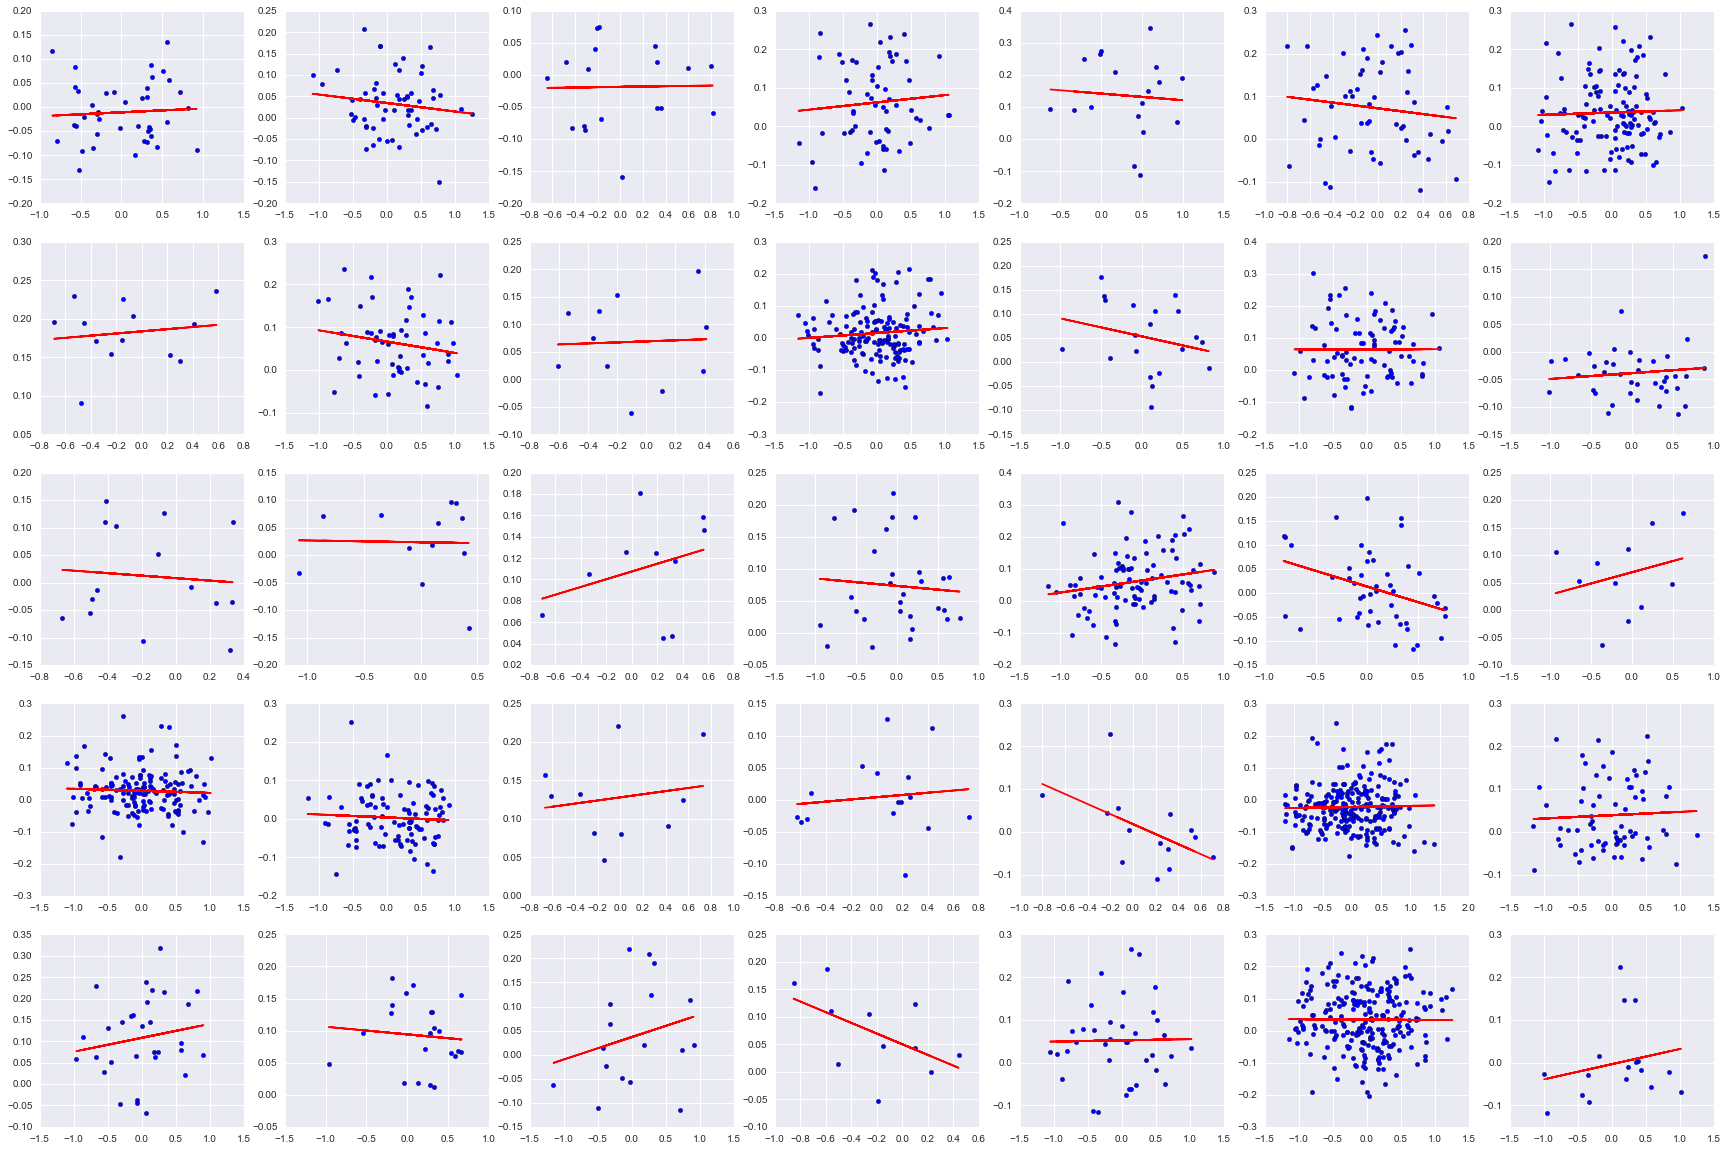

In [136]:
j = 1
plt.figure(figsize=(30, 20))
user_validation = user_hot[data["validation"]["observations"],:]

for i in range(len(data["validation"]["users"])):
    user_test_set = np.any(user_validation[:, [data["validation"]["users"][i]]], axis = 1).nonzero()[0]
    
    if (len(user_test_set)) >= 10:
        plt.subplot(5, 7, j)
        j += 1

        ypred = svr.predict(data["validation"]["X"][user_test_set,:])

        y = np.ravel(likes[user_test_set])
        plt.scatter(y, ypred)
#         print('rmse:' + str(calculate_rmse(y, ypred)))

        lin = linear_model.LinearRegression()
        lin.fit(y.reshape((-1, 1)), ypred)
        plt.plot(y, y * lin.coef_ + lin.intercept_, 'r')
        print("r^2: " + str(lin.score(y.reshape(-1,1), ypred)))

plt.savefig("svm_user_performance.png", dpi=300)

In [122]:
n = 0

for i in range(len(data["validation"]["users"])):
    user_test_set = np.any(user_hot[:, [data["validation"]["users"][i]]], axis = 1).nonzero()[0]
    if len(user_test_set) >= 10:
        n += 1
#     print(len(user_test_set))

n

35

In [131]:
user_validation.shape

(2450, 5863)

In [134]:
svr

SVR(C=0.01, cache_size=4000, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [135]:
svr_simple

SVR(C=0.1, cache_size=4000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)